# Dota2 Heroes KMeans Clustering
***




The purpose of this project is to cluster Dota2 heroes into two groups, core heroes and support heroes. In a Dota2 match, it is expected from the cores heroes to have a higher rate of growths than the support heroes. I will be clustering Dota2 heroes into cores and supports based on the amount of gold and experience they earn per minute. 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

**The Data**


The first data frame (df) contains imformation about Dota2 matches, which includes stuff like match id,hero id, gold per minute and experience per minute. The second data frame (df_hero) simply links each hero id to their actual hero name (i will merge the two dataframes at some point). 

In [2]:
df = pd.read_csv('/users/tamer/desktop/advanced_ds/data/players.csv')
df_hero = pd.read_csv('/users/tamer/desktop/advanced_ds/data/hero_names.csv')

In [3]:
col_names = df.columns.tolist()
#need to drop unnecessary columns
df.drop(columns = col_names[8:],axis = 0,inplace = True)
df.drop(columns = col_names[4:6],axis = 0,inplace = True)
df.head(10)

,match_id,account_id,hero_id,player_slot,gold_per_min,xp_per_min
0,0,0,86,0,347,362
1,0,1,51,1,494,659
2,0,0,83,2,350,385
3,0,2,11,3,599,605
4,0,3,67,4,613,762
5,0,4,106,128,397,524
6,0,0,102,129,303,369
7,0,5,46,130,452,517
8,0,0,7,131,189,223
9,0,6,73,132,496,456


It is time to prepare the data. First, I want to link each hero name to each hero_id. Second, we need to find the mean gold and experience per minute earned by each hero (grouped by heroes)

In [4]:
hero_lookup = dict(zip(df_hero['hero_id'],df_hero['localized_name']))
hero_lookup[0] = 'unknown'
name =[]

for index in df['hero_id']:
    name.append(hero_lookup[index])
    
df['hero']=name
clean_df = df.groupby('hero').agg({'gold_per_min': 'mean', 'xp_per_min':'mean'})
clean_df.head(5)

,gold_per_min,xp_per_min
hero,,
Abaddon,363.055287,417.260725
Alchemist,709.545455,577.001832
Ancient Apparition,313.147046,324.378054
Anti-Mage,554.192742,580.392827
Axe,400.109107,442.938274


Lets plot the data.

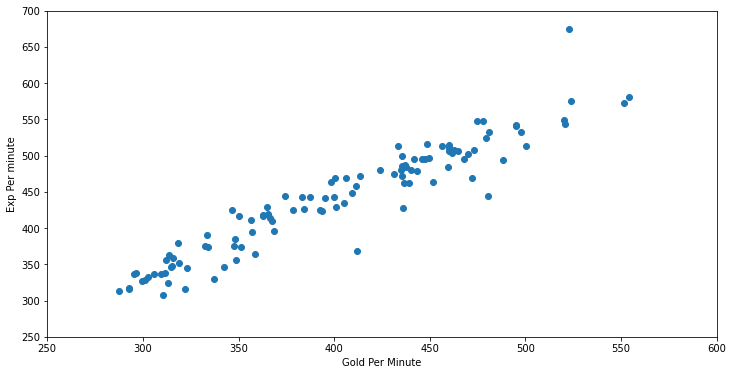

In [6]:
#example plot of mpg x hp
fig, ax= plt.subplots(figsize=(12,6))
plt.scatter(clean_df['gold_per_min'], clean_df['xp_per_min'])
plt.axis([250, 600, 250, 700])
ax.set_xlabel('Gold Per Minute')
ax.set_ylabel('Exp Per minute');

So lets start out Kmean! We are clustering into two groups so k =2. We need a distance measure, here we use euclidean distance. We pick the smallest and biggest x values as our initial centroids

In [7]:
#return distance between points.
def dist(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2)) #2-d euclidean distance


In [8]:
#most of this is borrowed from class notebooks
#Initialize
K = 2
print()
X = np.array(clean_df[['gold_per_min','xp_per_min']])
x1_coords = [x[0] for x in X]
centroids = np.array([X[x1_coords.index(min(x1_coords))], \
                      X[x1_coords.index(max(x1_coords))]])
dists = [0]*K
unnorm_clusters = np.array([-1]*len(X))


Run Kmeans until convergence. Here we decided that 100 steps are enough

In [9]:
for _ in range(100): #100 steps is fine; or a tolerance/change check.
    #update classifications
    for j in range(len(X)):
        dists = [dist(X[j], cent) for cent in centroids]
        assignment = dists.index(min(dists))
        unnorm_clusters[j] = assignment
    #update centroids
    for j in range(K):
        centroids[j]=[np.sum(X[unnorm_clusters==j,0])/len(X[unnorm_clusters==j,0]),np.sum(X[unnorm_clusters==j,1])/len(X[unnorm_clusters==j,1])]


Finally lets assign heroes to their clusters. if the return cluster by the algorithm is 1 then it is a Core and if it is a 0 then the hero is a support.

In [14]:
cluster_num = []
for i in range(len(clean_df)):
    cluster_num.append(unnorm_clusters[i])
cluster =[]
for i in cluster_num:
    if i == 1:
        cluster.append('Core')
    elif i == 0:
        cluster.append("Support")
clean_df['cluster_num'] = cluster_num
clean_df['clusters'] = cluster
clean_df.head(20)

,gold_per_min,xp_per_min,clusters,cluster_num
hero,,,,
Abaddon,363.055287,417.260725,Support,0
Alchemist,709.545455,577.001832,Core,1
Ancient Apparition,313.147046,324.378054,Support,0
Anti-Mage,554.192742,580.392827,Core,1
Axe,400.109107,442.938274,Core,1
Bane,295.293380,336.720329,Support,0
Batrider,362.856736,418.428843,Support,0
Beastmaster,384.134814,426.685170,Support,0
Bloodseeker,447.641746,494.835927,Core,1


The above results pass sanity check. We expect heroes like Alchemist anti-mage to be core since they have high rate of growth and we expect heros like Bane and Chen to be support heroes since they have lower rate of growth.

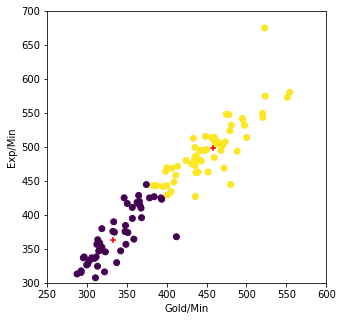

In [255]:
#final cluster plot
fig, ax = plt.subplots(1,1, figsize=(5,5))
plt.scatter([x[0] for x in X], [x[1] for x in X], c=unnorm_clusters)
plt.scatter([x[0] for x in centroids], [x[1] for x in centroids], c='red', marker='+')

plt.axis([250, 600, 300, 700])
plt.xlabel("Gold/Min")
plt.ylabel("Exp/Min")
plt.show()


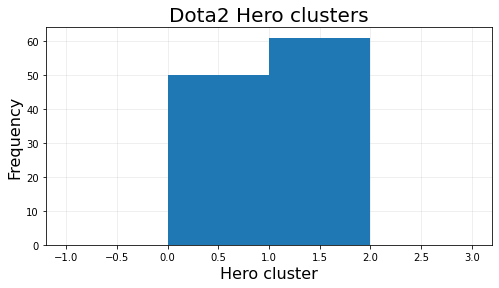

In [23]:
fig, ax = plt.subplots(figsize=(8,4))

# Plot histogram 
clean_df.hist(column="cluster_num", ax=ax,bins = range(-1,4));
ax.grid(alpha=0.25)
# Add a title
ax.set_title("Dota2 Hero clusters", fontsize=20)
# Add xis labels 
ax.set_xlabel("Hero cluster", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_axisbelow(True)
